In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from clustimage import Clustimage
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
import cv2
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

### Data Analysis
Reading csv file to create a image file path and the check the number of possible unique cluster.

In [3]:
df = pd.read_csv('chinese_mnist.csv')
df.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


Here we are finding the unique values and storing the suite_id, sample_id and code in index object to create a image path. I have observe in image name starts with 'input' and then there is underscore saperated suite_id, sample_id and code, which represents the value.<br>
Here we can see that our dataset has 15 unique values, we should be able to design a model which can give us 15 different clusters.

In [15]:
index = df.iloc[:,:-2].values 
value = df["code"].values
unique_values = len(np.unique(value))
print(f"Total Unique values: {unique_values}")

Total Unique values: 15


In [5]:
print(index.shape)
print(len(value))

(15000, 3)
15000


Here I am creating relative image path with help of 'index' object and storing the image data into listImageArray list by converting the image from color to gray scale. we have image lable data in the filename_label_link dictionary.

In [6]:
filename_label_link = {}

filename_list = []
label_list = []
listImageArray = []
listImageNameArray = [] 
for i in range(0,len(value)):
    codeImage= index[i]
    filename = f"input_{codeImage[0]}_{codeImage[1]}_{codeImage[2]}.jpg"
#     print(filename)
    val = value[i] 
    filename_label_link[filename] = val
    filename_list.append(filename)
    label_list.append(val)
    a = cv2.imread(f"data/{filename}", cv2.COLOR_BGR2RGB)
    listImageArray.append(a)
    listImageNameArray.append(val)

Here we can see that our listImageArray has 15000 samples and each sample size is 64X64 pixels. To train a model we have to reduce the dimesionality of the image and we can achieve that by flattening the image.

In [7]:
listImageArray = np.array(listImageArray)
listImageNameArray = np.array(listImageNameArray)
print(listImageArray.shape)
print(listImageNameArray.shape)

(15000, 64, 64)
(15000,)


In order to get flatten image we have used flatten() method and normalize the pixel value by dividing it to 255. Now we get the flatten image by arranging all the 64X64 pixels from 2D to 1D array with 15000 sample and each sample has 4096 pixels.

In [12]:
print("Before flatten:",listImageArray.shape)

listFlattened = []

for i in range(len(listImageArray)):
    listFlattened.append(listImageArray[i].flatten()/255)

listFlattened = np.array(listFlattened)
listFlattenedScale = scale(listFlattened)

print("After flatten:", listFlattenedScale.shape)

Before flatten: (15000, 64, 64)
After flatten: (15000, 4096)


Here, We are trying to fit our model by measuring the silhouette score on different number of cluster values, and we can observe that n_clusters=12 has the highest silhouette score which is 0.56 but if we look at the elbow method then as per the graph we can't predict the possible number of clusters as data is not very clustered. so in this case it's better to use silhoette score instead of elbow method.
Silhoette Score:- It is a measure of how similar an object is to its own cluster compared to other clusters it ranges from -1 to 1.<br>
<li>1: Means clusters are well apart from each other and clearly distinguished.</li><li>0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.</li><li>-1: Means clusters are assigned in the wrong way.</li>



For n_clusters = 9 The average silhouette_score is :0.3603957957104274
For n_clusters = 10 The average silhouette_score is :0.3767604990608886
For n_clusters = 11 The average silhouette_score is :0.3603200435395203
For n_clusters = 12 The average silhouette_score is :0.5645618435741473
For n_clusters = 13 The average silhouette_score is :0.4737643761401529
For n_clusters = 14 The average silhouette_score is :0.5388261706914521
For n_clusters = 15 The average silhouette_score is :0.3981414034806734
For n_clusters = 16 The average silhouette_score is :0.43275525189530006
For n_clusters = 17 The average silhouette_score is :0.3241238588980638


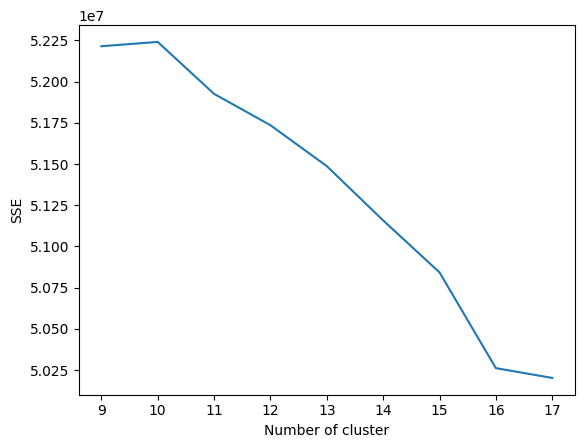

In [13]:
sse = {}
for k in range(9, 18):
    kmeans = KMeans(n_clusters=k, max_iter=300, n_init=10, random_state=0)
    kmeans.fit(listFlattenedScale)
    clusters = kmeans.fit_predict(listFlattenedScale)
    silhouette_avg = silhouette_score(listFlattenedScale, clusters)
    print(f"For n_clusters = {k} The average silhouette_score is :{silhouette_avg}")
#     print(kmeans.labels_)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Let's try to find the total value counts on our 12 different cluster prediction. Here I found that our model is inclied to the cluster_0 and cluster_1 only, Other clusters doesn't have much images in it. It means Kmeans algorithm is not able to perform as per the expectations.

In [30]:
kmeans = KMeans(n_clusters=12, max_iter=300, n_init=10, random_state=0)
clusters = kmeans.fit_predict(listFlattenedScale)
print(pd.DataFrame(clusters).value_counts())

0     13859
1      1118
2         7
11        7
8         2
3         1
4         1
5         1
6         1
7         1
9         1
10        1
dtype: int64


### Conclusion:-
As per the data analysis on the csv file, we have observed that this dataset has 15 unique values which means our model should able to define 15 distinct clusters while as per the silhouetter score it seems our model is able distinguish the images into 12 clusters. As per these results, I can say that K-means is not the perfect choice to deal with chienese_mnist dataset, Deep adaptive clustering(deep learning method) could be the better approach to cluster the image dataset.

### Experiment
Here I have tried cluster the images with Clustimage() package, It uses the agglomerative clustering (not kmeans). In agglomerative clustering algorithm can stop at any number of clusters, if it find appropriate by interpreting the dendrogram. Using this method we get the 10 clusters on silhouette evaluation.

In [33]:
# cl = Clustimage()
# results = cl.fit_transform(listFlattenedScale)
cl = Clustimage(method='pca')

results = cl.fit_transform(listFlattenedScale, evaluate='silhouette', min_clust=10)

[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Scaling images..
[clustimage] >INFO> Writing images to tempdir [C:\Users\Jemin\AppData\Local\Temp\clustimage]
100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:21<00:00, 703.74it/s]
[clustimage] >INFO> Extracting features using method: [pca]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [4096] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [943] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [4096] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Extracted features using [pca]: samples=15000, features=943
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [pca] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [06:06<00:00, 16.66s/it]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (15000, 943) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


[clustimage] >INFO> filepath is set to [C:\Users\Jemin\AppData\Local\Temp\clustimage]
[clustimage] >INFO> filepath is set to [C:\Users\Jemin\AppData\Local\Temp\clustimage]
[clustimage] >INFO> filepath is set to [C:\Users\Jemin\AppData\Local\Temp\clustimage]
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Scaling images..
[clustimage] >INFO> Writing images to tempdir [C:\Users\Jemin\AppData\Local\Temp\clustimage]
100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [00:20<00:00, 725.92it/s]
[clustimage] >INFO> Extracting features using method: [pca]


[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [4096] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [943] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [4096] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.


[clustimage] >INFO> Extracted features using [pca]: samples=15000, features=943
[clustimage] >INFO> Compute [tsne] embedding
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [pca] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward
[clusteval] >Evaluate using silhouette.


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:22<00:00, 13.48s/it]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (15000, 943) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [10].
[clusteval] >Fin.


Here I have plot the unique sample values from all 10 clusters.

[10940, 14477, 2294, 5375, 11931, 7927, 6466, 9992, 14541, 2971]


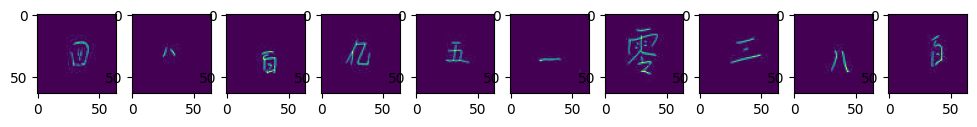

In [34]:
unique_samples = cl.unique()
X = listImageArray
# print(unique_samples.keys())
print(unique_samples['idx'])

X = X[unique_samples['idx'],:]
# Value = listImageNameArray[unique_samples['idx']]

_, axs = plt.subplots(1, len(X), figsize=(12, 12))
axs = axs.flatten()
for i, ax in enumerate(axs):
    try:
#         ax.set_title(str(Value[i]))
        ax.imshow(X[i])
    except IndexError:
        pass